# INST728E - Module 9. Topic Modeling

Along with sentiment analysis, a question often asked of social networks is "What are people talking about?" We can answer this question using tools from topic modeling and natural language processing. With crises, people can have many responses, from sharing specific data about the event, sharing condolonces, or opening their homes to those in need.

To generate these topic models, we will use the Gensim package's implementation of Latent Dirichlet Allocation (LDA), which basically constructs a set of topics where each topic is described as a probability distribution over the words in our tweets. Several other methods for topic modeling exist as well.

In [10]:
%matplotlib inline

import datetime
import json
import string
import os

import numpy as np

# For plotting
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

## Event Description

In [1]:
crisisInfo = {
    "Women's March": {
        "name": "Women's March 2017",
        "time": 1484992800, # 21 January 2017, 6:58 UTC to 08:11 UTC
        "directory": "womensmarch",    # Where do we find the relevant files
        "keywords": [    # How can we describe this event?
            "women's march","resist", "notmypresident","inauguration","women's right","human right","planned parenthood"
        ],
        "place": [
            38.899539,# Latitude
            -77.036551 # Longitude
        ],
        "box": {    # Where did this event occur?
            "lowerLeftLon": -77.119759,
            "lowerLeftLat": 38.791645,
            "upperRightLon": -76.909393,
            "upperRightLat": 38.995548,
        }
    },
}

In [2]:
# Replace the name below with your selected crisis
selectedCrisis = "Women's March"


<hr>

## Reading Relevant Tweets

Re-read our relevant tweets...

In [4]:


in_file_path = "/Users/yutingliao/Desktop/INST728 E/relevant_tweet_output_keywords_updated.json" # Replace this as necessary

relevant_tweets = []
with open(in_file_path, "r") as in_file:
    for line in in_file:
        relevant_tweets.append(json.loads(line.encode("utf8")))
        
print("Relevant Tweets:", len(relevant_tweets))

Relevant Tweets: 4447


## Temporal Ordering

In [5]:
# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

# Frequency map for tweet-times
rel_frequency_map = {}
for tweet in relevant_tweets:
    # Parse time
    currentTime = datetime.datetime.strptime(tweet['created_at'], timeFormat)

    # Flatten this tweet's time
    currentTime = currentTime.replace(second=0)

    # If our frequency map already has this time, use it, otherwise add
    extended_list = rel_frequency_map.get(currentTime, [])
    extended_list.append(tweet)
    rel_frequency_map[currentTime] = extended_list
    
# Fill in any gaps
times = sorted(rel_frequency_map.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

# We want to look at per-minute data, so we fill in any missing minutes
timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
while ( thisTime <= lastTime ):

    rel_frequency_map[thisTime] = rel_frequency_map.get(thisTime, [])
        
    thisTime = thisTime + timeIntervalStep

# Count the number of minutes
print ("Start Time:", firstTime)
print ("Stop Time:", lastTime)
print ("Processed Times:", len(rel_frequency_map))

Start Time: 2017-01-21 10:01:00
Stop Time: 2017-01-24 23:58:00
Processed Times: 5158


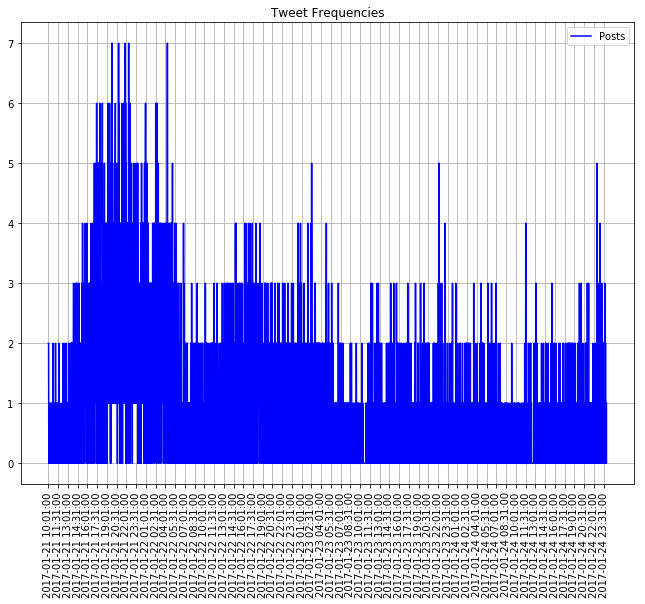

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequencies")

sortedTimes = sorted(rel_frequency_map.keys())
postFreqList = [len(rel_frequency_map[x]) for x in sortedTimes]

smallerXTicks = range(0, len(sortedTimes), 90)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

ax.plot(xData, postFreqList, color="blue", label="Posts")

ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

<hr> 

## Hashtags as Topics

Hashtags generally have a topical connotation, so let's regenerate the common hashtags we've seen before.

In [11]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the hashtags list
htags = [
        hashtag["text"].lower() 
         for tweet in relevant_tweets 
             for hashtag in tweet["entities"]["hashtags"]
        ]

print("\nTotal Hashtag Count:", len(htags))
print("Unique Hashtag Count:", len(set(htags)))

htags_freq = nltk.FreqDist(htags)

print("\nFrequent Hashtags:")
for tag, count in htags_freq.most_common(20):
    print(tag, count)


Total Hashtag Count: 2658
Unique Hashtag Count: 783

Frequent Hashtags:
womensmarch 533
theresistance 285
resist 115
notmypresident 111
resistance 74
trumpleaks 50
resisttrump 44
trump 34
whyimarch 30
womensmarchonwashington 27
resisttrumptuesdays 27
inauguration 21
lovatics 21
breaking 20
bestfanarmy 20
alternativefacts 20
indivisible 20
iheartawards 19
resistfromday1 14
breakingnews 12


<hr> 

## Topic Modeling with Gensim

A big part of topic modeling is pre-processing your data. 

For our context, that includes:

- Which tokens are used so frequently as to be useless?
- Which tokens are so rare as to be uninformative?
- How should we handle phrases versus single words (called n-grams)?

We'll explore this feature extraction below.

In [12]:
# Gotta pull in a bunch of packages for this

# Actual LDA implementation
import gensim.models.ldamulticore

# Actual ATM implementation
import gensim.models.atmodel

# CountVectorizer turns tokens into numbers for us
from sklearn.feature_extraction.text import CountVectorizer

# Gensim models
from gensim.corpora import Dictionary  # All the words that appear in our dataset
from gensim.models import TfidfModel # For down-weighting frequent tokens
from gensim.models.phrases import Phrases # For building bigrams

Now we build a list of stop words using NLTK and other words we don't care about.

In [30]:
# But first, read in stopwrods
enStop = stopwords.words('english')
frStop = stopwords.words('french')
esStop = stopwords.words('spanish')

# Skip stop words, retweet signs, @ symbols, and URL headers
stopList = enStop +\
    frStop + esStop +\
    ["http", "https", "rt", "@", ":", "co", "amp", "&amp;", "...", "\n", "\r"] +\
    crisisInfo[selectedCrisis]["keywords"]
stopList.extend(string.punctuation)

For memory/performance reasons, we don't want to carry around strings of characters when doing topic modeling. Instead, we can convert our tweets into a "bag of words" (BoW) model, in which a tweet is made up of words and their frequencies in that tweet. Then, for each word, we replace it with a specific indexed integer. The BoW model loses contextual information about which words occur before or after each other in the tweet, but we can address this with bigrams (to a degree).

As an example, consider the following sets of tweets:

1. "my best friend lives in brussels and my friend isn’t responding",
1. "Wish all but the best out to Brussels this morning",
1. "So horrible. My thoughts are with the people in Brussels",

We can extract the following unique words from these tweets:
{'.',
 'all',
 'and',
 'are',
 'best',
 'brussels',
 'but',
 'friend',
 'horrible',
 'in',
 'isn',
 'lives',
 'morning',
 'my',
 'out',
 'people',
 'responding',
 'so',
 't',
 'the',
 'this',
 'thoughts',
 'to',
 'wish',
 'with',
 '’'}
 
From there, we can replace these tokens with indices: [(0, 'friend'),
 (1, 'lives'),
 (2, 'all'),
 (3, 'my'),
 (4, 'the'),
 (5, 'this'),
 (6, 'but'),
 (7, 'thoughts'),
 (8, 'best'),
 (9, 'and'),
 (10, 'are'),
 (11, 'so'),
 (12, '’'),
 (13, 't'),
 (14, 'in'),
 (15, '.'),
 (16, 'brussels'),
 (17, 'responding'),
 (18, 'wish'),
 (19, 'people'),
 (20, 'morning'),
 (21, 'with'),
 (22, 'out'),
 (23, 'to'),
 (24, 'isn'),
 (25, 'horrible')]
 
Then we can convert tweets into the BoW model:

1. "my best friend lives in brussels and my friend isn’t responding" --> [(0, 2), (1, 1), (3, 2), (8, 1), (9, 1), (12, 1), (14, 1), (16, 1), (17, 1), (24, 1)]
    - "my" and "friend" occur twice, and their pairs (0, 2) and (3, 2) reflect this.
1. "Wish all but the best out to Brussels this morning", --> [(2, 1), (4, 1), (5, 1), (6, 1), (8, 1), (16, 1), (18, 1), (20, 1), (22, 1), (23, 1)]

In [14]:
vectorizer = CountVectorizer(strip_accents='unicode', 
                             tokenizer=TweetTokenizer(preserve_case=False).tokenize,
                             stop_words=stopList)

# Build the Analyzer
analyze = vectorizer.build_analyzer() 

# For each tweet, tokenize it according to the CountVectorizer
analyzed_text = [analyze(tweet["text"]) for tweet in relevant_tweets]

# As an example, note the removed stopwords
print(relevant_tweets[0]["text"])
print(analyzed_text[0])

RT @EvelynRBertrand: Women's March LA is already taking over Pershing Square. Here are some of the brilliant designs.… 
['@evelynrbertrand', "women's", 'march', 'already', 'taking', 'pershing', 'square', 'brilliant', 'designs']


In [15]:
# Make bigrams from the text, but only for really common bigrams
bigram = Phrases(analyzed_text, min_count=5)
bi_analyzed_text = [bigram[x] for x in analyzed_text]

# As an example, note the removed stopwords
print(relevant_tweets[0]["text"])
print(analyzed_text[0])
print(bi_analyzed_text[0])

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


RT @EvelynRBertrand: Women's March LA is already taking over Pershing Square. Here are some of the brilliant designs.… 
['@evelynrbertrand', "women's", 'march', 'already', 'taking', 'pershing', 'square', 'brilliant', 'designs']
['@evelynrbertrand', "women's_march", 'already', 'taking', 'pershing', 'square', 'brilliant', 'designs']


In [16]:
# Build a dictionary from this text
dictionary = Dictionary(bi_analyzed_text)

# Filter out words that occur too frequently or too rarely.
# Disregarding stop words, this dataset has a very high number of low frequency words.
max_freq = 0.75
min_count = 5
dictionary.filter_extremes(no_below=min_count, no_above=max_freq)

# This sort of "initializes" dictionary.id2token.
_ = dictionary[0]

# Create a map for vectorizer IDs to words
id2WordDict = dictionary.id2token
word2IdDict = dict(map(lambda x: (x[1], x[0]), id2WordDict.items()))

# Create a bag of words
corpus = [dictionary.doc2bow(text) for text in analyzed_text]

# Train TFIDF model
tfidf_model = TfidfModel(corpus)

# Built TFIDF-transformed corpus
tfidf_corpus = [tfidf_model[text] for text in corpus]

We then use the vectorizer to transform our tweet text into a feature set, which essentially is a table with rows of tweets, columns for each keyword, and each cell is the number of times that keyword appears in that tweet.

We then convert that table into a model the Gensim package can handle, apply LDA, and grab the top 10 topics, 10 words that describe that topic, and print them.

In [31]:
k = 10

lda = gensim.models.LdaMulticore(tfidf_corpus, 
                                 id2word=id2WordDict,
                                 num_topics=k) # ++ iterations for better results

ldaTopics = lda.show_topics(num_topics=k, 
                            num_words=10, 
                            formatted=False)

for (i, tokenList) in ldaTopics:
    print ("Topic %d:" % i, ' '.join([pair[0] for pair in tokenList]))
    print()

Topic 0: march women's rights marches #theresistance could washington human planned today

Topic 1: #theresistance #womensmarch rights #notmypresident march women's washington human absolutely people

Topic 2: march women's rights #womensmarch washington today #notmypresident #resist trump human

Topic 3: rights march women's black p change disabled education matter lives

Topic 4: march vs trump's women's rights https://t.co/ylcmrdaxqi parenthood planned @mikefarrell #womensmarch

Topic 5: rights trump women's marches march resistance #womensmarch women via world

Topic 6: trump's vs #womensmarch march rights parenthood planned human women's next

Topic 7: resistance rights march #womensmarch women's planned parenthood human 2017 dc

Topic 8: march vs women's trump's washington rights resistance #theresistance #womensmarch ️

Topic 9: march women's rights #womensmarch resistencia today washington human via women



## Visualized Topics

In [32]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [33]:
pyLDAvis.gensim.prepare(lda, tfidf_corpus, dictionary)

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      10.872345        1       1 -0.029478  0.033437
3      10.761920        1       2  0.068220  0.002830
6      10.558291        1       3  0.018250 -0.107080
7      10.286598        1       4 -0.000587  0.005455
1       9.902598        1       5 -0.081423  0.009071
5       9.697603        1       6 -0.026314 -0.053698
8       9.696780        1       7  0.019407  0.025724
2       9.689439        1       8 -0.026587  0.035758
4       9.570070        1       9  0.081717  0.034812
0       8.964357        1      10 -0.023206  0.013690, topic_info=     Category        Freq                      Term       Total  loglift  \
term                                                                       
406   Default   71.000000                        vs   71.000000  30.0000   
238   Default   79.000000                   trump's   79.000000  29.0000   
895   Default   14.000000   https://t.co/ylcmrdaxqi   14.000000  28.0000   
855   Default   22.000000              @mikefarrell   22.000000  27.0000   
632   Default   32.000000                 education   32.000000  26.0000   
767   Default   40.000000           #notmypresident   40.000000  25.0000   
474   Default   31.000000                         p   31.000000  24.0000   
807   Default   34.000000                  disabled   34.000000  23.0000   
1236  Default   26.000000               resistencia   26.000000  22.0000   
510   Default   37.000000                     black   37.000000  21.0000   
584   Default   34.000000                    change   34.000000  20.0000   
391   Default   76.000000            #theresistance   76.000000  19.0000   
1130  Default   32.000000                    matter   32.000000  18.0000   
1004  Default   32.000000                     lives   32.000000  17.0000   
999   Default   13.000000                absolutely   13.000000  16.0000   
482   Default   16.000000   https://t.co/0svs9qe1dm   16.000000  15.0000   
1483  Default   63.000000                parenthood   63.000000  14.0000   
925   Default   11.000000                         ั   11.000000  13.0000   
857   Default   12.000000   https://t.co/oqbkf6wxko   12.000000  12.0000   
695   Default   18.000000                  congress   18.000000  11.0000   
23    Default   17.000000                     could   17.000000  10.0000   
28    Default   73.000000                washington   73.000000   9.0000   
330   Default   24.000000                      next   24.000000   8.0000   
85    Default   13.000000  #womensmarchonwashington   13.000000   7.0000   
1274  Default    7.000000                  resistir    7.000000   6.0000   
1587  Default   18.000000                screenings   18.000000   5.0000   
44    Default   64.000000                   planned   64.000000   4.0000   
362   Default   18.000000              https://t.co   18.000000   3.0000   
43    Default  171.000000                     march  171.000000   2.0000   
1513  Default    7.000000                     gover    7.000000   1.0000   
...       ...         ...                       ...         ...      ...   
377   Topic10    3.128824                  gathered   11.433874   1.1160   
638   Topic10    8.364971                   marches   46.933000   0.6872   
797   Topic10    4.912932                         u   23.803027   0.8340   
1010  Topic10    3.556917                    trying   14.453354   1.0099   
40    Topic10    4.285598                      city   20.991766   0.8230   
669   Topic10    2.463008                       may    8.175648   1.2121   
1087  Topic10    2.716625                      text    9.762742   1.1327   
391   Topic10    7.885754            #theresistance   76.097484   0.1450   
150   Topic10    3.663351                organizers   17.444491   0.8513   
43    Topic10   11.510489                     march  171.199907  -0.2877   
123   Topic10   10.093233                

## Author-Topic Models

Social media messages have an additional dimension we can leverage for identifying topics: their authors. If we make the assumption that, given all possible topics, a single user is only likely to tweet about a small number of them, then we can get some additional insight based on this data.

We'll try this below.

In [21]:
# Simple pipepline for analyzing tweet text
def analysis_pipeline(text):
    a1 = analyze(text)
    a2 = bigram[a1]
    a3 = dictionary.doc2bow(a2)
    a4 = tfidf_model[a3]

    return a4

analyzed_tweet_pairs = list(
    filter(lambda x: len(x[0]) > 0,
           [(analysis_pipeline(tweet["text"]), tweet["user"]["id"]) 
            for tweet in relevant_tweets])
)

atm_docs = [x[0] for x in analyzed_tweet_pairs]
doc_to_author = dict([(x, [y[1]]) for x, y in enumerate(analyzed_tweet_pairs)])

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [35]:
k = 10

atm = gensim.models.atmodel.AuthorTopicModel(corpus=atm_docs, 
                                             id2word=id2WordDict,
                                             doc2author=doc_to_author,
                                             num_topics=k) # ++ iterations for better results

atmTopics = atm.show_topics(num_topics=k, 
                            num_words=10, 
                            formatted=False)

for (i, tokenList) in atmTopics:
    print ("Topic %d:" % i, ' '.join([pair[0] for pair in tokenList]))
    print()

Topic 0: screenings breaking turned abortion women's fund bill texas away i'll

Topic 1: screenings place give https://t.co/c9u5g0didn like body choice https://t.co/azbu5nc0af #istandwithpp walking

Topic 2: screenings rights need office resistencia “ trump everything women's women

Topic 3: screenings wo oh defund wait state trump government https://t.co/azbu5nc0af signs

Topic 4: screenings order defund place https://t.co/azbu5nc0af gives https://t.c 100 https://t.co/c9u5g0didn abortions

Topic 5: screenings p care ‘ ’ must americans already trump brown

Topic 6: screenings defund thats https://t.co/azbu5nc0af #notmypresident sign rule footage https://t.co/c9u5g0didn we've

Topic 7: screenings like get funding wo https://t.co/azbu5nc0af https://t.co/c9u5g0didn would god defund

Topic 8: screenings https://t.co/azbu5nc0af fighting pro-life linda vs thing goes rights h

Topic 9: screenings https://t.co/azbu5nc0af #theresistance @mashable washington else anyone https://t.co/c9u5g0didn s

## Per-Topic Times

Now we can graph each topic over time.

In [38]:
topic_counter = {x:[0]*len(rel_frequency_map) for x in range(lda.num_topics)}

In [39]:
for (i, d) in enumerate(rel_frequency_map.keys()):
    tweets = rel_frequency_map[d]
    
    for tweet in tweets:
        text = tweet["text"]
        topic_dist = lda.get_document_topics(analysis_pipeline(text))
        
        top_topic = sorted(topic_dist, key=lambda x: x[1])[-1][0]
        
        topic_counter[top_topic][i] += 1

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


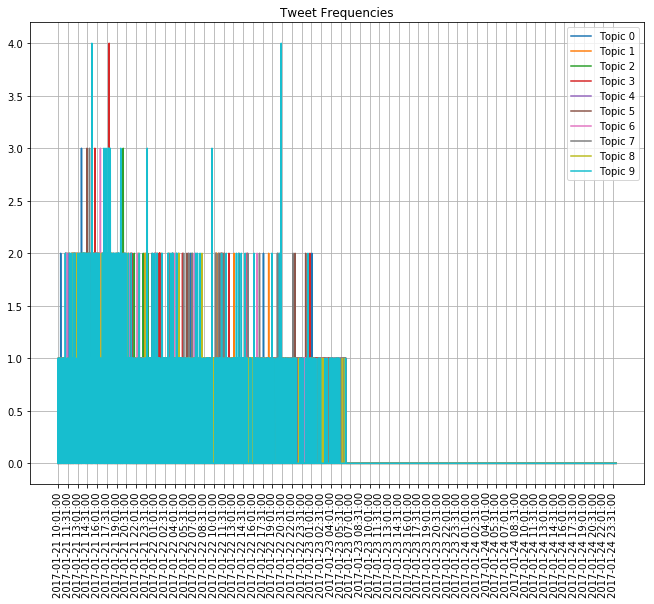

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequencies")

smallerXTicks = range(0, len(sortedTimes), 90)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

for this_k in range(lda.num_topics):
    plt.plot(xData, topic_counter[this_k], label="Topic %d" % (this_k))

ax.grid(b=True, which=u'major')
ax.legend()

plt.show()